In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import MSELoss
import time

import warnings
warnings.filterwarnings("ignore")

from laser_jitter.data import TimeSeries, TimeSeriesSTFT
from laser_jitter.model_basic import LSTMForecaster
from laser_jitter.model import RNNTemporal, RNNSTFT, RNNSTFT_real_imag, RNNSTFT_ensemble
from laser_jitter.train import train_model

In [2]:
N = 5
smooth_params = {
    'kernel': np.ones(N)/N,
}

data = pd.read_csv("/home/wi73yus/focus_deviation/data/cryo07_decFULL.csv", header=None)
data = data.rename({0: 'real_time', 1:'focus_location'}, axis=1)
data['time_idx'] = np.arange(len(data['real_time']))

ts_data = np.array(data['focus_location'])

### TimeSeries

In [3]:
ts = TimeSeries(ts_data[:10000], smooth_params=smooth_params, train_size=0.8)

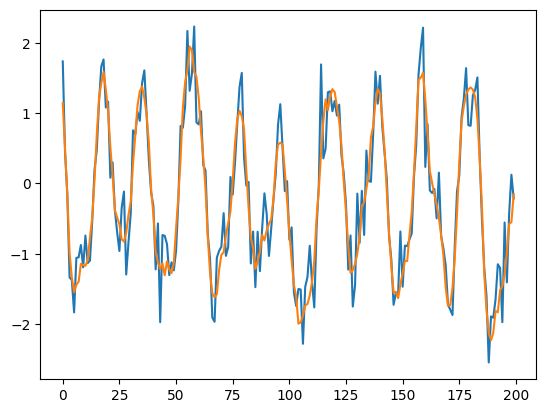

In [4]:
idx = 200
plt.figure()
plt.plot(ts.test[:idx])
plt.plot(ts.test_smooth[:idx])
plt.show()

In [5]:
sequence_params = {
    'training_window': 200,
    'prediction_window': 100,
    'step': 1
}

dataloader_params = {
    'batch_size': 64,
    'shuffle': False,
    'drop_last': False,
}


loaders = ts.create_dataloaders(ts.train, ts.test, sequence_params, dataloader_params)
trainloader, testloader = loaders
loaders_smooth = ts.create_dataloaders(ts.train_smooth, ts.test_smooth, sequence_params,
                                       dataloader_params)
trainloader_smooth, testloader_smooth = loaders_smooth

In [6]:
for (x,y), (x_smooth, y_smooth) in zip(trainloader, trainloader_smooth):
    print(x.shape, y.shape)
    break

torch.Size([64, 200, 1]) torch.Size([64, 100, 1])


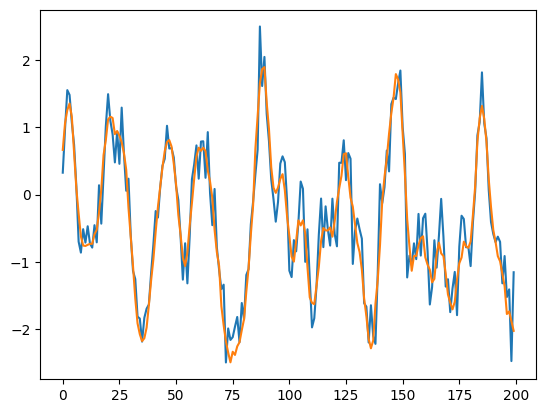

In [7]:
i = 50
idx = 200
plt.figure()
plt.plot(x[i,:idx])
plt.plot(x_smooth[i,:idx])
plt.show()

### TimeSeriesSTFT

In [15]:
stft_params = {
    'nperseg': 500, # window_length
    'fs': 1e3,
    'boundary': None,
    'noverlap': 499,
    'padded': False,
    'window': 'tukey'
}

filter_params = {
    'thresh_weight': 1,
    'freq_low': 0
}

ts = TimeSeriesSTFT(ts_data[:10000], stft_params, train_size=0.8, filter_params=filter_params)

array([0.25 , 0.251, 0.252, ..., 7.748, 7.749, 7.75 ])

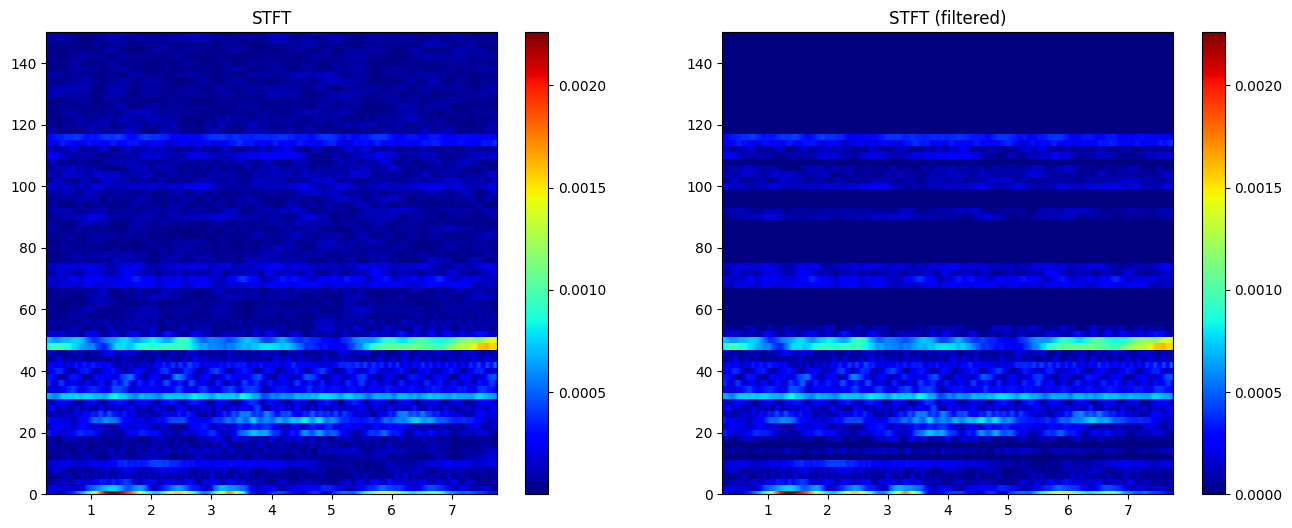

In [9]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.pcolormesh(ts.t, ts.freq, np.abs(ts.train_stft), cmap='jet')
plt.colorbar()
plt.ylim([0,150])
plt.title('STFT')


plt.subplot(122)
plt.pcolormesh(ts.t, ts.freq, np.abs(ts.train_stft_filt), cmap='jet')
plt.colorbar()
plt.ylim([0,150])
plt.title('STFT (filtered)')
plt.show()

In [10]:
sequence_params = {
    'training_window': 200,
    'prediction_window': 100,
    'step': 1
}

dataloader_params = {
    'batch_size': 64,
    'shuffle': False,
    'drop_last': False,
}


loaders = ts.create_dataloaders(ts.train_real, ts.train_imag, ts.test_real, ts.test_imag,
                                sequence_params, dataloader_params)
trainloader, testloader = loaders

In [11]:
for x,y in trainloader:
    print(x.shape, y.shape)
    break

torch.Size([64, 200, 80]) torch.Size([64, 100, 80])


### Basic_model

In [24]:
n_features = 1
training_window = 200
prediction_window = 100
use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'
batch_size = 1

model_params = {
    'n_features': n_features,
    'n_hidden_lstm': 128,
    'n_hidden_fc': 128,
    'n_outputs': prediction_window*n_features,
    'sequence_len': training_window,
    'n_lstm_layers': 3,
    'n_deep_layers': 1,
    'dropout': 0.2,
    'use_cuda': use_cuda
}

model = LSTMForecaster(**model_params)
x = torch.Tensor(np.random.uniform(size=(batch_size,training_window,n_features)))#.to(device)
print(x.shape)

prediction = model(x).detach().cpu().numpy()
prediction = prediction.reshape((batch_size,prediction_window,n_features))

print(prediction.shape)

torch.Size([1, 200, 1])
(1, 100, 1)


### Temporal model
TODO: check rms of smoothed series -> that's the upper limit for quality of prediction

In [3]:
smooth_params = {
    'kernel': np.ones(N)/N,
}

ts = TimeSeries(ts_data, smooth_params=smooth_params, train_size=0.8)

training_window = 200
prediction_window = 100
sequence_params = {
    'training_window': training_window,
    'prediction_window': prediction_window,
    'step': 1
}

dataloader_params = {
    'batch_size': 128,
    'drop_last': False,
}

loaders = ts.create_dataloaders(ts.train, ts.test, sequence_params, dataloader_params)
trainloader, testloader = loaders

loaders = ts.create_dataloaders(ts.train_smooth, ts.test_smooth, sequence_params,
                                dataloader_params)
trainloader_smooth, testloader_smooth = loaders

In [4]:
n_features = 1
use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'

model_params = {
    'n_features': n_features,
    'n_hidden_lstm': 64,
    'n_hidden_fc': 500,
    'n_outputs': prediction_window*n_features,
    'sequence_len': training_window,
    'n_lstm_layers': 2,
    'n_deep_layers': 1,
    'dropout': 0.2,
    'use_cuda': use_cuda
}
save_folder = 'models/rnn/'
load_model = False

model = LSTMForecaster(**model_params).to(device) if not load_model else None
model_high_level = RNNTemporal(model_params, model, save_folder, load_model=load_model)

In [5]:
lr = 1e-4
n_epochs = 30

# Initialize the loss function and optimizer
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW(model_high_level.model.parameters(), lr=lr)

In [6]:
losses = model_high_level.train(trainloader_smooth, testloader_smooth,
                                criterion, optimizer, n_epochs=n_epochs)

0 - train: 0.6013107265883345, valid: 0.2909289500836668
1 - train: 0.276373003677624, valid: 0.2575882077217102
2 - train: 0.25163032102391003, valid: 0.24488754776017418
3 - train: 0.24115308549830583, valid: 0.23671867775505986
4 - train: 0.23262867622259187, valid: 0.2287855369263682
5 - train: 0.22474974842090917, valid: 0.2241437753726696
6 - train: 0.21799006900651668, valid: 0.21774265632547182
7 - train: 0.2123730695102273, valid: 0.21487186592200708
8 - train: 0.207986903747892, valid: 0.21001258852152987
9 - train: 0.20349242653304, valid: 0.20695653455010776
10 - train: 0.19932908292223767, valid: 0.2057394678222722
11 - train: 0.19474940256374637, valid: 0.1999619253750505
12 - train: 0.1901960448036349, valid: 0.1969315681991906
13 - train: 0.18475379498024297, valid: 0.1921398500944006
14 - train: 0.17924254769232215, valid: 0.18847518362875643
15 - train: 0.17430585271459284, valid: 0.18362658111185864
16 - train: 0.16875419614276266, valid: 0.17979486466481767
17 - tra

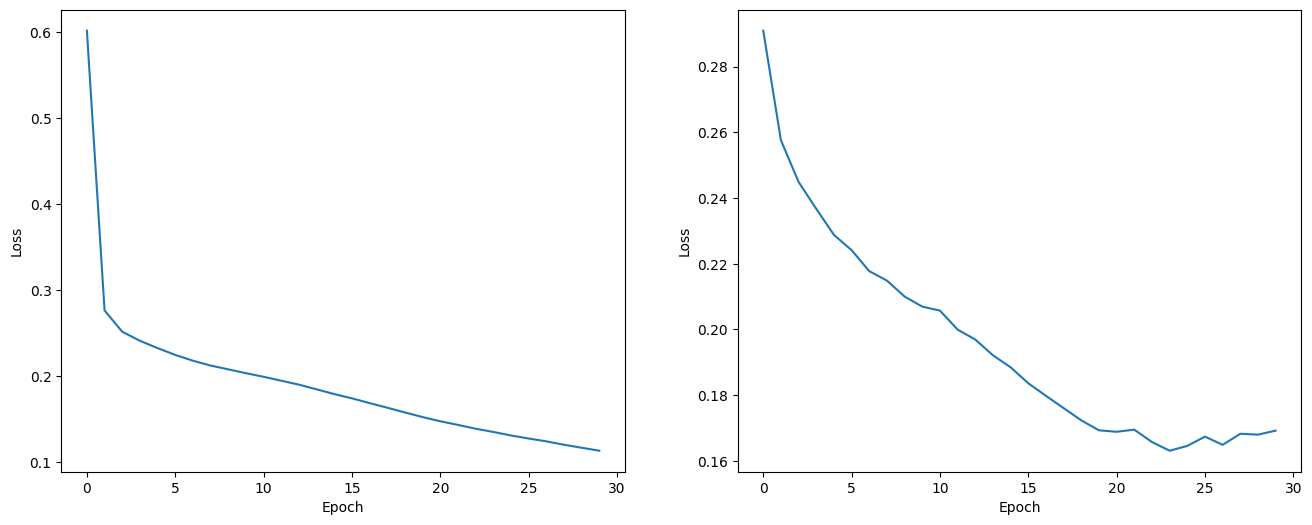

In [7]:
plt.figure(figsize=(16,6))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.plot(losses[i])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
plt.show()

#### Inference

In [8]:
model = model_high_level.load_best_model()

data, metrics = model_high_level.inference_on_dataloader(testloader, testloader_smooth)
predictions, actuals, actuals_smooth = data

n_batches = len(predictions)
predictions = ts.inverse_transform_series(predictions.flatten())
predictions = predictions.reshape((n_batches,prediction_window))
actuals_smooth = ts.inverse_transform_series(actuals_smooth.flatten())
actuals_smooth = actuals_smooth.reshape((n_batches,prediction_window))
actuals = ts.inverse_transform_series(actuals.flatten(), scaler=ts.scaler)
actuals = actuals.reshape((n_batches,prediction_window))

metrics = [ts.inverse_transform_series(np.array([metric])).squeeze() for metric in metrics]

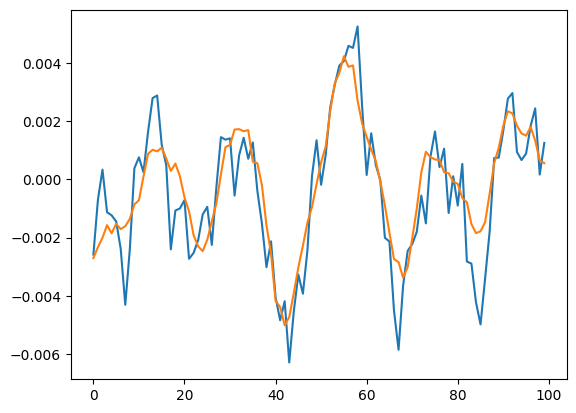

In [9]:
idx = 2500
plt.figure()
plt.plot(actuals[idx])
plt.plot(predictions[idx])
plt.show()

In [10]:
print(f'mae: {metrics[0]}')
print(f'rms: {metrics[1]}')

mae: 0.0010902030626311898
rms: 0.0013400852913036942


In [11]:
# use_cuda = torch.cuda.is_available()
models = []
save_folder = 'models/rnn/'
for use_cuda in [False, True]:
    device = 'cuda' if use_cuda else 'cpu'
    
    model_params = {
        'n_features': n_features,
        'n_hidden_lstm': 64,
        'n_hidden_fc': 500,
        'n_outputs': prediction_window*n_features,
        'sequence_len': training_window,
        'n_lstm_layers': 2,
        'n_deep_layers': 1,
        'dropout': 0.2,
        'use_cuda': use_cuda
    }

    model = None #LSTMForecaster(**model_params).to(device)
    model_high_level = RNNTemporal(model_params, model, save_folder, load_model=True)
    models.append(model_high_level)

In [12]:
t0 = 17500
N = 5

past_start, past_end = t0-N//2, t0+training_window+N//2 
future_start, future_end = t0+training_window+N//2, t0+training_window+N//2+prediction_window
series_past = ts.series[past_start:past_end].squeeze()
series_future = ts.series[future_start:future_end].squeeze()

predictions = []
devices = ['cpu', 'cuda']
for i,device in enumerate(devices):
    models[i].model.eval()
    t_start = time.time()
    prediction = models[i].predict_on_series(series_past, ts, device=device)
    t_pred = time.time() - t_start
    predictions.append(prediction)
    print('Prediction time ({}): {:3.1f} ms'.format(device, t_pred*1e3))

Prediction time (cpu): 77.2 ms
Prediction time (cuda): 1.5 ms


rms (initial): 0.002468301142486467
rms          : 0.0018399121539640062


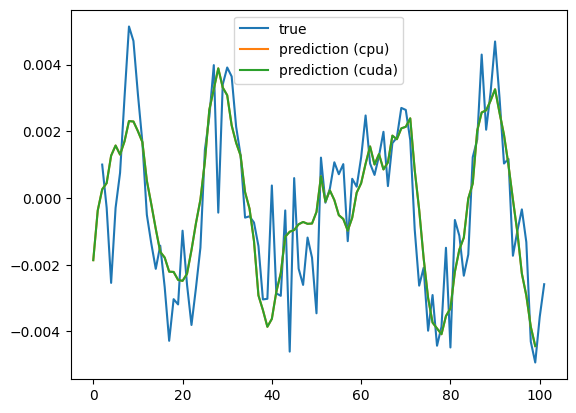

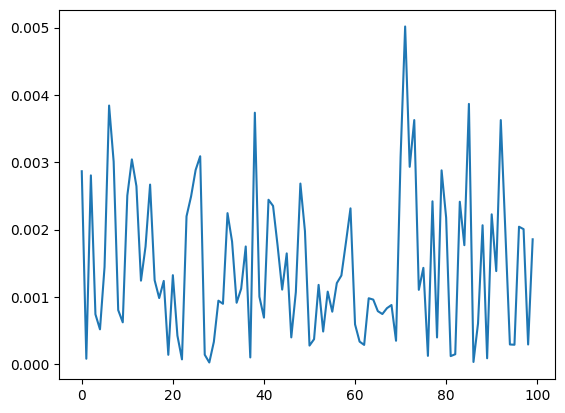

In [13]:
err = np.abs(series_future - prediction)
rms_ini = np.sqrt(np.mean(series_future**2))
rms = np.sqrt(np.mean(err**2))
print(f'rms (initial): {rms_ini}')
print(f'rms          : {rms}')

plt.figure()
plt.plot(np.arange(prediction_window)+2, series_future, label='true')
for i in range(2):
    plt.plot(predictions[i], label=f'prediction ({devices[i]})')
plt.legend()
plt.show()

plt.figure()
plt.plot(np.abs(series_future - prediction))
plt.show()

### Spectral model

#### One model for real/imag part of all frequency bands
TODO: how input vector changes inside LSTM network (features dimension in particular),
do we have a bottleneck regarding how many units we use?

In [3]:
window_length = 500
stft_params = {
    'nperseg': window_length,
    'fs': 1e3,
    'boundary': None,
    'noverlap': window_length-1,
    'padded': False,
    'window': 'tukey'
}

filter_params = {
    'thresh_weight': 1,
    'freq_low': 0
}

ts = TimeSeriesSTFT(ts_data, stft_params, train_size=0.8, filter_params=filter_params)

training_window = 300
prediction_window = 150
forecast_window = 100
sequence_params = {
    'training_window': training_window,
    'prediction_window': prediction_window,
    'step': 1
}

dataloader_params = {
    'batch_size': 64,
    'drop_last': False,
}


loaders = ts.create_dataloaders(ts.train_real, ts.train_imag, ts.test_real, ts.test_imag,
                                sequence_params, dataloader_params)
trainloader, testloader = loaders

In [4]:
n_features = len(ts.freq_filt)*2
use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'
print(device)

model_params = {
    'n_features': n_features,
    'n_hidden_lstm': 64,
    'n_hidden_fc': prediction_window*2,
    'n_outputs': prediction_window*n_features,
    'sequence_len': training_window,
    'n_lstm_layers': 2,
    'n_deep_layers': 1,
    'dropout': 0.2,
    'use_cuda': use_cuda
}
save_folder = 'models/rnn_stft_test/'
load_model = True

model = LSTMForecaster(**model_params).to(device) if not load_model else None
model_high_level = RNNSTFT(model_params, model, save_folder, load_model)

cuda


In [5]:
lr = 2e-4
n_epochs = 30

# Initialize the loss function and optimizer
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW(model_high_level.model.parameters(), lr=lr)

In [6]:
losses = model_high_level.train(trainloader, testloader,
                                criterion, optimizer, n_epochs=n_epochs)

0 - train: 0.665684578908702, valid: 0.4237301032990217
1 - train: 0.32198675374610947, valid: 0.28195705140630406
2 - train: 0.2097509433909998, valid: 0.209592727633814
3 - train: 0.1422225724021762, valid: 0.16892930725589395
4 - train: 0.10208109854641607, valid: 0.1501038564989964
5 - train: 0.07893036280648183, valid: 0.14505801582708955
6 - train: 0.06389197977101904, valid: 0.14373960082108775
7 - train: 0.053580697815297014, valid: 0.14486428163945675
8 - train: 0.04559697217102778, valid: 0.14429725799709558
9 - train: 0.0392843943120817, valid: 0.14521870839719972
10 - train: 0.03376682846159753, valid: 0.14560260763391852
11 - train: 0.029365142262777536, valid: 0.14772812277078629
12 - train: 0.02609601532408999, valid: 0.14819293391580382
13 - train: 0.02364092641431144, valid: 0.14977534829328457
14 - train: 0.021573355839729816, valid: 0.15034885704517365
15 - train: 0.0200576444661592, valid: 0.15146357178067169
16 - train: 0.018889209752807678, valid: 0.15215595811605

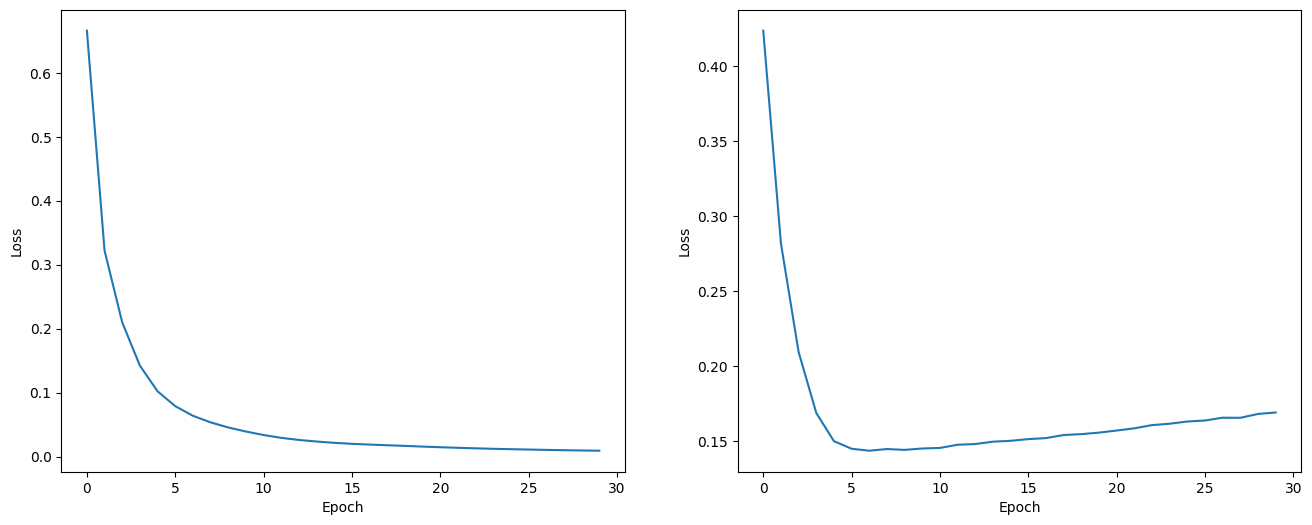

In [7]:
plt.figure(figsize=(16,6))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.plot(losses[i])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
plt.show()

##### Inference

In [5]:
t0 = 16000
train = ts_data[:t0]
test = ts_data[t0:]

In [6]:
data, metrics = model_high_level.inference_on_dataloader(test, ts, sequence_params,
                                                         dataloader_params,
                                                         forecast_window)

In [7]:
print(f'mae: {metrics[0].numpy()}')
print(f'rms: {metrics[1].numpy()}')

mae: 0.001163444365374744
rms: 0.0014654452679678798


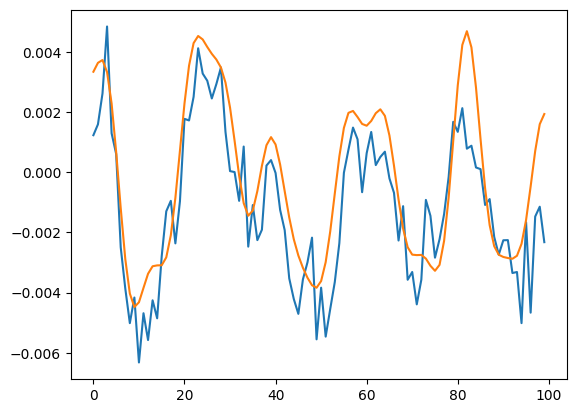

In [8]:
predictions, actuals = data

idx = 500
plt.figure()
plt.plot(actuals[idx])
plt.plot(predictions[idx])
plt.show()

In [9]:
# use_cuda = torch.cuda.is_available()
models = []
for use_cuda in [False, True]:
    device = 'cuda' if use_cuda else 'cpu'
    
    model_params = {
        'n_features': n_features,
        'n_hidden_lstm': 64,
        'n_hidden_fc': prediction_window*2,
        'n_outputs': prediction_window*n_features,
        'sequence_len': training_window,
        'n_lstm_layers': 2,
        'n_deep_layers': 1,
        'dropout': 0.2,
        'use_cuda': use_cuda
    }

    model = None #LSTMForecaster(**model_params).to(device)
    model_high_level = RNNSTFT(model_params, model, save_folder, load_model=True)
    models.append(model_high_level)

In [15]:
t0 = 17500
window_len = stft_params['noverlap']
forecast_window = 100

past_start, past_end = t0-window_len, t0+training_window 
future_start, future_end = t0+training_window, t0+training_window+forecast_window
series_past = ts.series[past_start:past_end].squeeze()
series_future = ts.series[future_start:future_end].squeeze()

predictions = []
devices = ['cpu', 'cuda']
for i,device in enumerate(devices):
    models[i].model.eval()
    t_start = time.time()
    prediction = models[i].predict_on_series(series_past, ts, device=device)
    prediction = prediction[-prediction_window:-prediction_window+forecast_window]
    t_pred = time.time() - t_start
    predictions.append(prediction)
    print('Prediction time ({}): {:3.1f} ms'.format(device, t_pred*1e3))

Prediction time (cpu): 52.8 ms
Prediction time (cuda): 6.4 ms


rms (initial): 0.0021564062210075357
rms          : 0.0013199502373256076


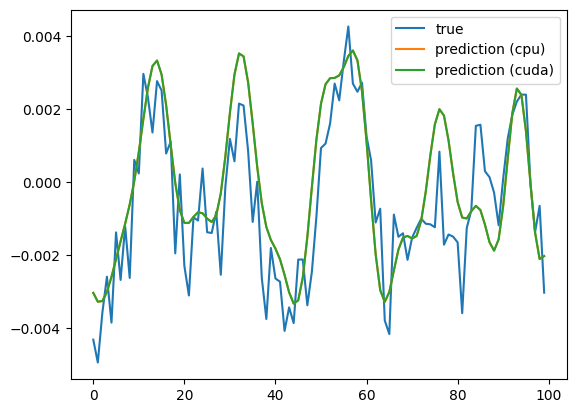

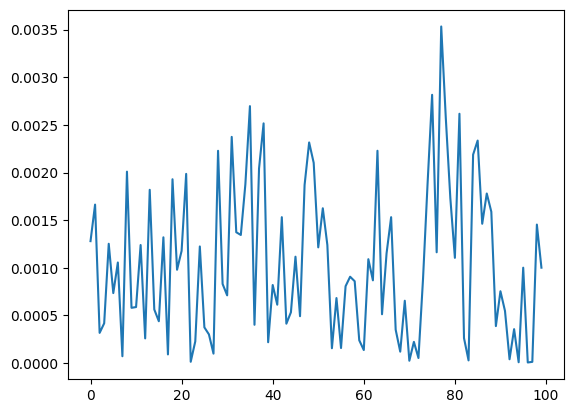

In [17]:
err = np.abs(series_future - prediction)
rms_ini = np.sqrt(np.mean(series_future**2))
rms = np.sqrt(np.mean(err**2))
print(f'rms (initial): {rms_ini}')
print(f'rms          : {rms}')

plt.figure()
plt.plot(np.arange(forecast_window), series_future, label='true')
for i in range(2):
    plt.plot(predictions[i], label=f'prediction ({devices[i]})')
plt.legend()
plt.show()

plt.figure()
plt.plot(np.abs(series_future - prediction))
plt.show()

#### One model for real part and another model for imag part

In [11]:
window_length = 500
stft_params = {
    'nperseg': window_length,
    'fs': 1e3,
    'boundary': None,
    'noverlap': window_length-1,
    'padded': False,
    'window': 'tukey'
}

filter_params = {
    'thresh_weight': 1,
    'freq_low': 0
}

ts = TimeSeriesSTFT(ts_data, stft_params, train_size=0.8, filter_params=filter_params)

training_window = 300
prediction_window = 150
forecast_window = 100
sequence_params = {
    'training_window': training_window,
    'prediction_window': prediction_window,
    'step': 1
}

dataloader_params = {
    'batch_size': 64,
    'drop_last': False,
}


loaders = ts.create_dataloaders(ts.train_real, ts.train_imag, ts.test_real, ts.test_imag,
                                sequence_params, dataloader_params)
trainloader, testloader = loaders

In [22]:
n_features = len(ts.freq_filt)
use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'
print(device)

model_params = {
    'n_features': n_features,
    'n_hidden_lstm': 152,
    'n_hidden_fc': 152, #prediction_window*4,
    'n_outputs': prediction_window*n_features,
    'sequence_len': training_window,
    'n_lstm_layers': 2,
    'n_deep_layers': 1,
    'dropout': 0.2,
    'use_cuda': use_cuda
}
save_folder = 'models/rnn_stft_real_imag/'
load_model = True

model = None #LSTMForecaster(**model_params).to(device) if not load_model else None
model_high_level = RNNSTFT_real_imag(model_params, model, save_folder, load_model)

cuda


In [14]:
lr = 2e-4
n_epochs = 30

# Initialize the loss function and optimizer
criterion = nn.MSELoss().to(device)
optimizer = [torch.optim.AdamW(model_high_level.model[i].parameters(), lr=lr) for i in range(2)]

In [15]:
losses = model_high_level.train(trainloader, testloader,
                                criterion, optimizer, n_epochs=n_epochs)

0 - train: 0.7289835995031615, valid: 0.46074556186795235
1 - train: 0.3444220450848846, valid: 0.29482215673973167
2 - train: 0.2326693551267608, valid: 0.22805925256883103
3 - train: 0.1718047917899439, valid: 0.1852804183339079
4 - train: 0.1273232400417328, valid: 0.15583821688778698
5 - train: 0.09762048323528241, valid: 0.14187814923934639
6 - train: 0.07847792636287415, valid: 0.13529094021456936
7 - train: 0.06599653461727045, valid: 0.1316074609446029
8 - train: 0.057033148467919584, valid: 0.12893870868720114
9 - train: 0.05034805281024615, valid: 0.12740808570136627
10 - train: 0.044693198086599176, valid: 0.12637831208606562
11 - train: 0.03987268659175705, valid: 0.1259880087648829
12 - train: 0.03559584909718547, valid: 0.1242690592383345
13 - train: 0.03189879162552751, valid: 0.12376357653799155
14 - train: 0.02857263144737078, valid: 0.12382924991349378
15 - train: 0.025866782470306347, valid: 0.12375039925488333
16 - train: 0.023704005456608484, valid: 0.1243762310283

KeyboardInterrupt: 

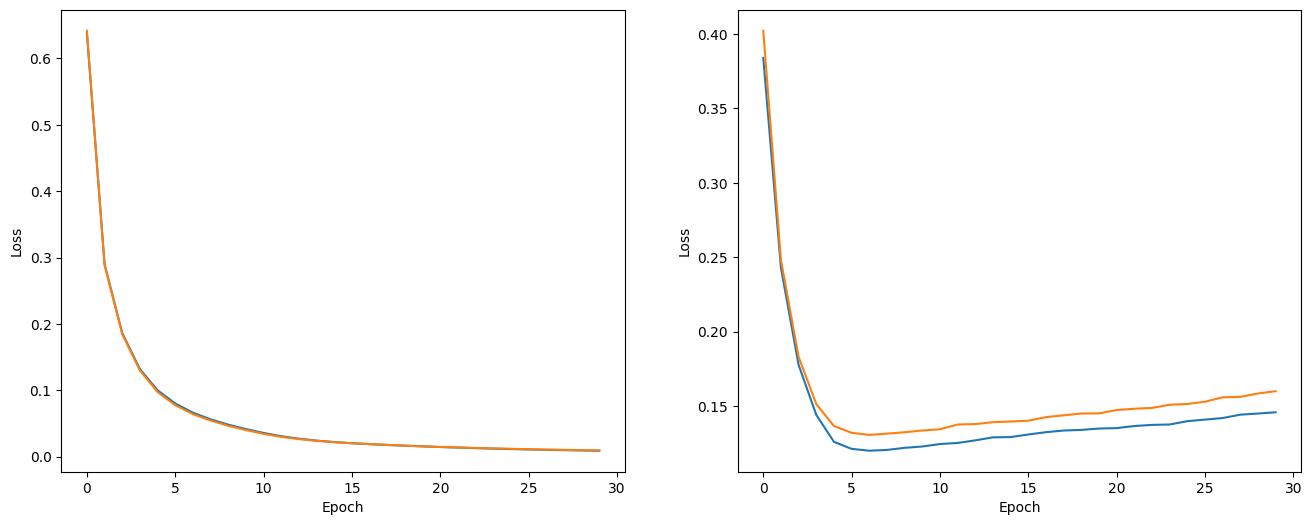

In [7]:
plt.figure(figsize=(16,6))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.plot(losses[i])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
plt.show()

##### Inference

In [33]:
t0 = 16000
train = ts_data[:t0]
test = ts_data[t0:]

data, metrics = model_high_level.inference_on_dataloader(test, ts, sequence_params,
                                                         dataloader_params,
                                                         forecast_window)

In [34]:
print(f'mae: {metrics[0].numpy()}')
print(f'rms: {metrics[1].numpy()}')

mae: 0.0011167930206283927
rms: 0.0014056522632017732


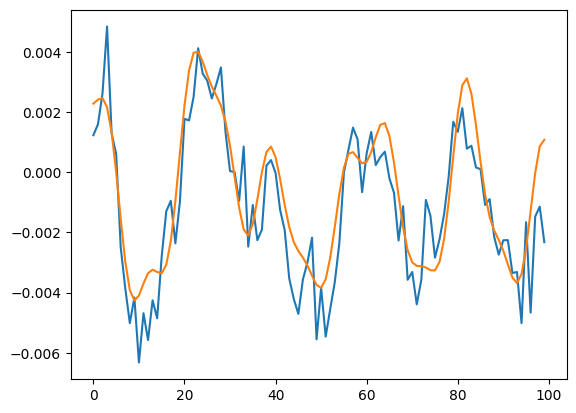

In [19]:
predictions, actuals = data

idx = 500
plt.figure()
plt.plot(actuals[idx])
plt.plot(predictions[idx])
plt.show()

In [27]:
# use_cuda = torch.cuda.is_available()
models = []
for use_cuda in [False, True]:
    device = 'cuda' if use_cuda else 'cpu'
    model_params = {
        'n_features': n_features,
        'n_hidden_lstm': 152,
        'n_hidden_fc': 152, #prediction_window*4,
        'n_outputs': prediction_window*n_features,
        'sequence_len': training_window,
        'n_lstm_layers': 2,
        'n_deep_layers': 1,
        'dropout': 0.2,
        'use_cuda': use_cuda
    }

    model = None #LSTMForecaster(**model_params).to(device)
    model_high_level = RNNSTFT_real_imag(model_params, model, save_folder, load_model=True)
    models.append(model_high_level)

In [29]:
t0 = 17500
window_len = stft_params['noverlap']
forecast_window = 100

past_start, past_end = t0-window_len, t0+training_window 
future_start, future_end = t0+training_window, t0+training_window+forecast_window
series_past = ts.series[past_start:past_end].squeeze()
series_future = ts.series[future_start:future_end].squeeze()

predictions = []
devices = ['cpu', 'cuda']
for i,device in enumerate(devices):
    for j in range(models[i].n_models):
        models[i].model[j].eval()
    t_start = time.time()
    prediction = models[i].predict_on_series(series_past, ts, device=device)
    prediction = prediction[-prediction_window:-prediction_window+forecast_window]
    t_pred = time.time() - t_start
    predictions.append(prediction)
    print('Prediction time ({}): {:3.1f} ms'.format(device, t_pred*1e3))

Prediction time (cpu): 117.1 ms
Prediction time (cuda): 18.0 ms


rms (initial): 0.0021564062210075357
rms          : 0.00128003862929202


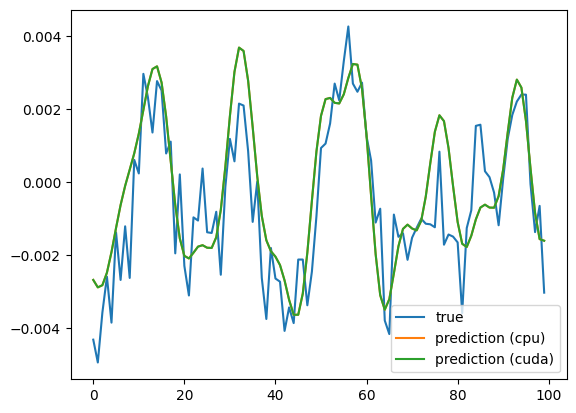

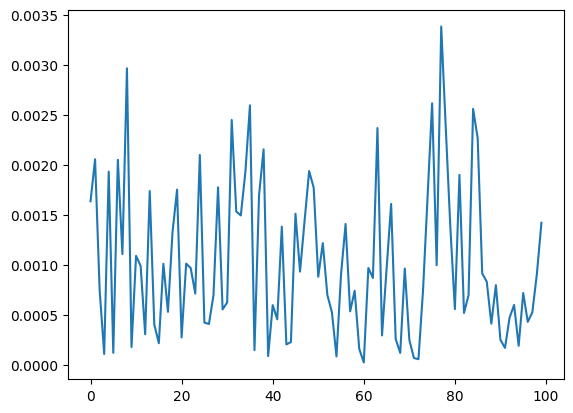

In [30]:
err = np.abs(series_future - prediction)
rms_ini = np.sqrt(np.mean(series_future**2))
rms = np.sqrt(np.mean(err**2))
print(f'rms (initial): {rms_ini}')
print(f'rms          : {rms}')

plt.figure()
plt.plot(np.arange(forecast_window), series_future, label='true')
for i in range(2):
    plt.plot(predictions[i], label=f'prediction ({devices[i]})')
plt.legend()
plt.show()

plt.figure()
plt.plot(np.abs(series_future - prediction))
plt.show()

#### Separate model for each frequency band

In [3]:
window_length = 500
stft_params = {
    'nperseg': window_length,
    'fs': 1e3,
    'boundary': None,
    'noverlap': window_length-1,
    'padded': False,
    'window': 'tukey'
}

filter_params = {
    'thresh_weight': 1,
    'freq_low': 0
}

ts = TimeSeriesSTFT(ts_data, stft_params, train_size=0.8, filter_params=filter_params)
n_models = len(ts.freq_filt)

training_window = 300
prediction_window = 150
forecast_window = 100
sequence_params = {
    'training_window': training_window,
    'prediction_window': prediction_window,
    'step': 1
}

dataloader_params = {
    'batch_size': 64,
    'drop_last': False,
}


loaders = ts.create_dataloaders(ts.train_real, ts.train_imag, ts.test_real, ts.test_imag,
                                sequence_params, dataloader_params)
trainloader, testloader = loaders

In [4]:
n_features = 2
use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'
print(device)

model_params = {
    'n_features': n_features,
    'n_hidden_lstm': 128,
    'n_hidden_fc': 152, #prediction_window*4,
    'n_outputs': prediction_window*n_features,
    'sequence_len': training_window,
    'n_lstm_layers': 2,
    'n_deep_layers': 1,
    'dropout': 0.2,
    'use_cuda': use_cuda
}
save_folder = 'models/rnn_stft_ensemble/'
load_model = True

model = None #LSTMForecaster(**model_params).to(device) if not load_model else None
model_high_level = RNNSTFT_ensemble(model_params, model, save_folder, load_model, n_models)

cuda


In [5]:
lr = 2e-4
n_epochs = 30

# Initialize the loss function and optimizer
criterion = nn.MSELoss().to(device)
optimizer = [torch.optim.AdamW(model_high_level.model[i].parameters(), lr=lr) for i in range(n_models)]

In [6]:
losses = model_high_level.train(trainloader, testloader,
                                criterion, optimizer, n_epochs=n_epochs)

0 - train: 0.3000278738102762, valid: 0.13932287211089656
1 - train: 0.12305228657901356, valid: 0.11995643715399347
2 - train: 0.10900962089061177, valid: 0.11308737125606665
3 - train: 0.10099763355807563, valid: 0.10615064119994914
4 - train: 0.09529502842371608, valid: 0.10339600718861408
5 - train: 0.09148111358236843, valid: 0.10162552113624337
6 - train: 0.0881557822108103, valid: 0.09954748521970093
7 - train: 0.08497442513580931, valid: 0.09835470201469725
8 - train: 0.08232525540971013, valid: 0.0955859677367063
9 - train: 0.07978520070574632, valid: 0.09316935975212323
10 - train: 0.07751083006049075, valid: 0.09467821716325056


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(16,6))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.plot(losses[i])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
plt.show()

##### Inference

In [5]:
t0 = 16000
train = ts_data[:t0]
test = ts_data[t0:]

data, metrics = model_high_level.inference_on_dataloader(test, ts, sequence_params,
                                                         dataloader_params,
                                                         forecast_window)

In [6]:
print(f'mae: {metrics[0].numpy()}')
print(f'rms: {metrics[1].numpy()}')

mae: 0.0011882237158715725
rms: 0.0015122935874387622


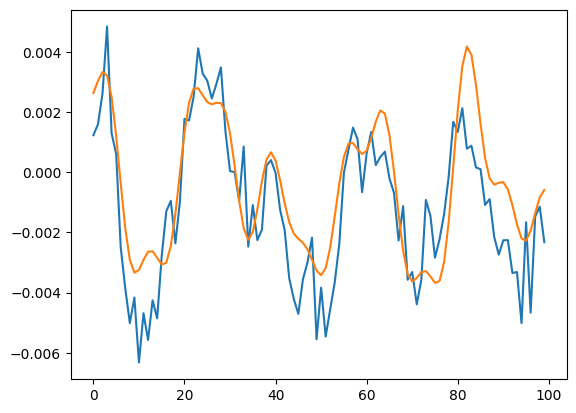

In [7]:
predictions, actuals = data

idx = 500
plt.figure()
plt.plot(actuals[idx])
plt.plot(predictions[idx])
plt.show()

In [8]:
# use_cuda = torch.cuda.is_available()
models = []
for use_cuda in [False, True]:
    device = 'cuda' if use_cuda else 'cpu'
    model_params = {
        'n_features': n_features,
        'n_hidden_lstm': 128,
        'n_hidden_fc': 152, #prediction_window*4,
        'n_outputs': prediction_window*n_features,
        'sequence_len': training_window,
        'n_lstm_layers': 2,
        'n_deep_layers': 1,
        'dropout': 0.2,
        'use_cuda': use_cuda
    }

    model = None #LSTMForecaster(**model_params).to(device)
    model_high_level = RNNSTFT_ensemble(model_params, model, save_folder, load_model=True,
                                        n_models=n_models)
    models.append(model_high_level)

In [10]:
t0 = 17500
window_len = stft_params['noverlap']
forecast_window = 100

past_start, past_end = t0-window_len, t0+training_window 
future_start, future_end = t0+training_window, t0+training_window+forecast_window
series_past = ts.series[past_start:past_end].squeeze()
series_future = ts.series[future_start:future_end].squeeze()

predictions = []
devices = ['cpu', 'cuda']
for i,device in enumerate(devices):
    for j in range(models[i].n_models):
        models[i].model[j].eval()
    t_start = time.time()
    prediction = models[i].predict_on_series(series_past, ts, device=device)
    prediction = prediction[-prediction_window:-prediction_window+forecast_window]
    t_pred = time.time() - t_start
    predictions.append(prediction)
    print('Prediction time ({}): {:3.1f} ms'.format(device, t_pred*1e3))

Prediction time (cpu): 1583.8 ms
Prediction time (cuda): 74.0 ms


rms (initial): 0.0021564062210075357
rms          : 0.0012353161666914987


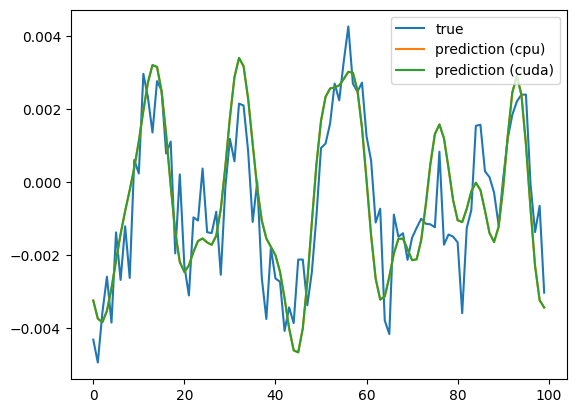

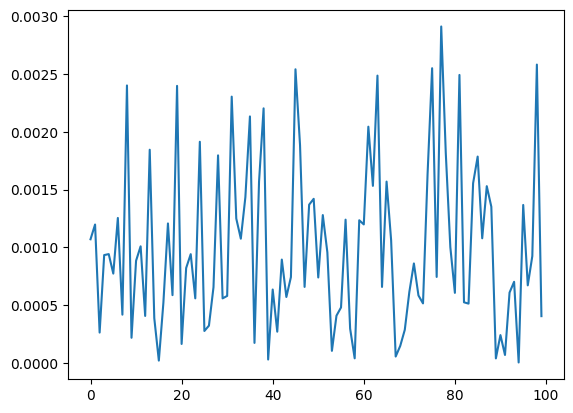

In [11]:
err = np.abs(series_future - prediction)
rms_ini = np.sqrt(np.mean(series_future**2))
rms = np.sqrt(np.mean(err**2))
print(f'rms (initial): {rms_ini}')
print(f'rms          : {rms}')

plt.figure()
plt.plot(np.arange(forecast_window), series_future, label='true')
for i in range(2):
    plt.plot(predictions[i], label=f'prediction ({devices[i]})')
plt.legend()
plt.show()

plt.figure()
plt.plot(np.abs(series_future - prediction))
plt.show()